### Assignment 1
*Sharanya Saha*<br>
21111056 <br>
*sharanya21@iitk.ac.in*

In [1]:
#Importing required librarie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from copy import deepcopy
import random

In [2]:
from brian2 import *

## Integrate-and-fire neuron model

This is one of the simplest models of neuron behavior. It omits all the intricacies of what goes on electrochemically inside the neuron's body, and simply attempts to capture the basic 'accumulate till a threshold and then fire and let go of all the accumulation' aspect of a neuron's activity 

$$\frac{dv}{dt} = \frac{(v_0 - v)}{\tau},$$

where $v$ is the membrane voltage of the neuron, and $\tau$ is a timescale factor.

In [3]:
v0 = 1
tau = 10*ms
eqs = '''
dv/dt = (v0-v)/tau : 1
'''

In [4]:
G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')
M = StateMonitor(G, 'v', record=True)
spikemon = SpikeMonitor(G)

Text(0, 0.5, 'v')

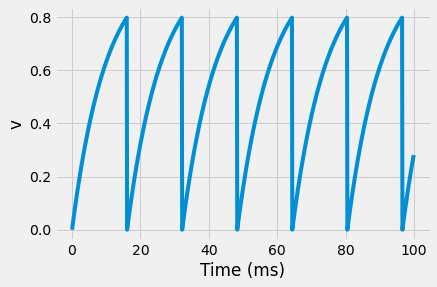

In [5]:
run(100*ms)
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v')

## Hopfield network model

In this simplified Hopfied model, each neuron can only take values +1 or -1. The network stores pixel patterns, and attempts to retrieve them given some cue in the form of a part of the original pattern used to set an initial state $S_i(t=0)$ for every neuron in the network. The network activation of all the neurons evolves as follows

$$S_i(t+1) = sgn\left(\sum_j{w_{ij} S_j(t)}\right), $$

where the weight of every synaptic connection is calculated as,

$$w_{ij} = \frac{1}{N} \sum_{\mu}{p_i^\mu p_j^\mu}, $$

where in turn, $N$ is the number of neurons, and $p_i^\mu$ is the state of the $i^{th}$ neuron for encoding pattern $\mu$.

The code below is taken from this [link](https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/hopfield-network.html). Follow the accompanying exercises to be better prepared for your assignment. Remember to install all needed libraries before trying to run it. 

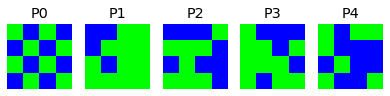

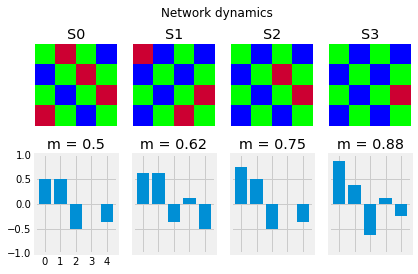

In [6]:
%matplotlib inline
from neurodynex3.hopfield_network import network, pattern_tools, plot_tools

pattern_size = 4

# create an instance of the class HopfieldNetwork
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_size**2)
# instantiate a pattern factory
factory = pattern_tools.PatternFactory(pattern_size, pattern_size)
# create a checkerboard pattern and add it to the pattern list
checkerboard = factory.create_checkerboard()
pattern_list = [checkerboard]

# add random patterns to the list
pattern_list.extend(factory.create_random_pattern_list(nr_patterns=4, on_probability=0.5))
plot_tools.plot_pattern_list(pattern_list)
# how similar are the random patterns and the checkerboard? Check the overlaps
overlap_matrix = pattern_tools.compute_overlap_matrix(pattern_list)
#plot_tools.plot_overlap_matrix(overlap_matrix)

# let the hopfield network "learn" the patterns. Note: they are not stored
# explicitly but only network weights are updated !
hopfield_net.store_patterns(pattern_list)

# create a noisy version of a pattern and use that to initialize the network
noisy_init_state = pattern_tools.flip_n(checkerboard, nr_of_flips=4)
hopfield_net.set_state_from_pattern(noisy_init_state)

# from this initial state, let the network dynamics evolve.
states = hopfield_net.run_with_monitoring(nr_steps=3)

# each network state is a vector. reshape it to the same shape used to create the patterns.
states_as_patterns = factory.reshape_patterns(states)
# plot the states of the network
plot_tools.plot_state_sequence_and_overlap(states_as_patterns, pattern_list, reference_idx=0, suptitle="Network dynamics")


## Our own Hopfield network model

You will write your own code to build a Hopfield network. I am leaving sample expected results below as a guide. 

Q1. Can you write you own Hopfield network model that works more or less like the one simulated above? (20 points)

Q2. Run the model with different parameters to figure out how the model's capacity to retrieve the correct pattern in response to a cue deteriorates as a function of 
(a) the informativeness of the cue
(b) the number of other patterns stored in the network
(c) the size of the network

Present your answers with plots and/or math. (20 points)

Q3. Can you write a function that converts MNIST digit [data](https://gitlab.com/datapythonista/mnist) to the sort of patterns used in this simulation? (20 points)

Q4. Can you write an MNIST classifier using the Hopfield network?. Can you characterize its performance using F-score, and compare with [classical](https://github.com/ksopyla/svm_mnist_digit_classification) and [deep](https://github.com/hwalsuklee/tensorflow-mnist-cnn) supervised learning methods? Remember that you can always use multiple samples of the same digit even for the Hopfield network classifier. Summarize your sense of the merits and demerits of using a Hopfield network as a classifier (40 points) 

### Hopfield Network:

In [7]:
import random

The function below returns a list of patterns, where num is the number of patterns in the list. Each pattern has a dimension of pattern_size*pattern_size  

In [8]:
def get_patterns(pattern_size,num):
    patterns=[]
    for i in range(num) :
        matrix=[]
        for j in range(pattern_size) :
            row=[]
            for k in range(pattern_size) :
                row.append(random.choice([1,-1])) 
            matrix.append(row)
        patterns.append(np.array(matrix))
    return patterns
    

The function below takes two arguements, a pattern and the number of bitflips. It returns the pattern by randomly flipping *bitflips* number of bits.

In [9]:
def perturb_pattern(pattern,bitflips) :
    p=np.array(pattern)
    size=len(pattern[0])
    flat=p.flatten() 
    num=p.size
    randomlist = random.sample(range(0, num), bitflips) #Randomly generating the indexes to be flipped
    for i in randomlist :
        if flat[i] == -1 :
            flat[i]=1
        else :
            flat[i]=-1
    noisy=np.reshape(flat,(size,size))
    return noisy

The function below returns the weight matrix. <br>
The weight matrix is of dimension $ N * N $ where, N = pattern_size$^{2}$. <br>
The weights are updated in accordance to Hebb's Learning Rule.<br>

In [10]:
def calculate_weights(pattern_list,pattern_size) :
    weights=np.array([[0]*(pattern_size**2)]*(pattern_size**2))
    p_flat_list=[]
    for i in range(len(pattern_list)) :
        flat=pattern_list[i].flatten()
        p_flat_list.append(np.array(flat))
    
    p_flat=np.array(p_flat_list)
    weights=np.matmul(p_flat.T,p_flat)
    np.fill_diagonal(weights,0)
    return weights/pattern_size**2 

The next state is calculated using the current state and the given weights. <br>
The function returns the next state.

In [11]:
def network_evolution(State, weights):
    pattern_size=len(State)
    state_flat=State.flatten()
    update=np.multiply(weights,state_flat)
    update=np.sum(update,axis=1)
    update[update>0]=1
    update[update<=0]=-1
    update=update.reshape(pattern_size,pattern_size)
    return np.array(update)
    

The function below is the implementation of the Hopfield Network :

In [12]:
def hopfield_network(pattern_size=4,num_of_patterns=5,bitflips=3,plots=False) :  
    plist = get_patterns(pattern_size,num_of_patterns)
    #plot_tools.plot_pattern_list(plist)

    cue = deepcopy(plist)

    S = perturb_pattern(cue[0],bitflips)

    wghts = calculate_weights(plist, pattern_size)

    state_list =[S]
    #state_list.append(S)
    #print(state_list)
    #plot_tools.plot_pattern(S)
    for i in range(4):
        state_list.append(network_evolution(S,wghts))
        S=state_list[-1]
        
    overlap = pattern_tools.compute_overlap(state_list[-1], plist[0]) #Computes the overlap between pattern1 and the final state.
    
    if plots == True : #Plots the resuls
        plot_tools.plot_pattern_list(plist)
        #print(state_list[0])
        plot_tools.plot_pattern(state_list[0])
        plot_tools.plot_state_sequence_and_overlap(state_list, plist, reference_idx=0, suptitle="Network dynamics")
        
    return overlap

#### Visualizing the results obtained using the Hopfield Network created above:
- Pattern size= 4
- Number of patterns = 5
- Number of perturbs = 3

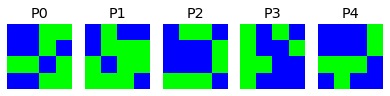

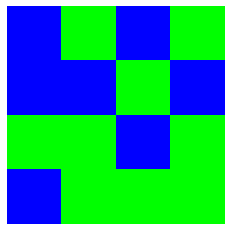

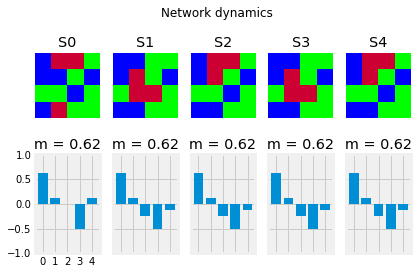

0.625

In [13]:
hopfield_network(pattern_size=4,num_of_patterns=5,bitflips=3,plots=True)

### Experimenting on different parameters:

#### A. The informativeness of the cue:
Analysing the behaviour of the network on increasing the number of bitflips.<br> Each datapoint has been iterated thrice and then the mean has been taken into account so as to reduce the effect of randomness. <br><br>

- Pattern size = 10
- Number of bits flipped are in the range 1 to 100

In [14]:
pattern_size=10
num_of_patterns=10
m_score_10=[]
for bitflip in range(100) :
    m=[]
    for i in range(3) :
        m.append(hopfield_network(pattern_size,num_of_patterns,bitflip,plots=False))
    m_score_10.append(np.mean(m))

In [15]:
pattern_size=10
num_of_patterns=15
m_score_15=[]
for bitflip in range(100) :
    m=[]
    for i in range(3) :
        m.append(hopfield_network(pattern_size,num_of_patterns,bitflip,plots=False))
    m_score_15.append(np.mean(m))

In [16]:
pattern_size=10
num_of_patterns=20
m_score_20=[]
for bitflip in range(100) :
    m=[]
    for i in range(3) :
        m.append(hopfield_network(pattern_size,num_of_patterns,bitflip,plots=False))
    m_score_20.append(np.mean(m))

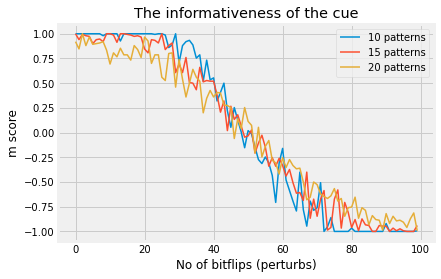

In [17]:
plt.plot(m_score_10,linewidth=1.5)
plt.plot(m_score_15,linewidth=1.5)
plt.plot(m_score_20,linewidth=1.5)
plt.legend(['10 patterns','15 patterns','20 patterns'], loc='upper right')
plt.xlabel('No of bitflips (perturbs)')
plt.ylabel('m score')
plt.title('The informativeness of the cue')
plt.show()

The plot above is somewhat noisy with a downward trend. The network's ability to extract information decreases as the number of bits flipped increases, regardless of how many different patterns are stored in the network.

#### B. Number of other patterns stored in the network :
<br>
Analysing the behaviour of the model with increase in number of patterns stored in the network.<br>
Each datapoint has been iterated thrice and then the mean has been taken into account so as to reduce the effect of randomness.<br><br>

- The number of patterns stored in the network are taken in the range 1 to 75. <br>
- Pattern size is taken as 10.

In [18]:
m_score_3=[]
pattern_size=10
bitflip=3
for num_of_patterns in range(1,75) :
    m=[]
    for i in range(3) :
        m.append(hopfield_network(pattern_size,num_of_patterns,bitflip,plots=False))
    m_score_3.append(np.mean(m))

In [19]:
pattern_size=10
bitflip=5
m_score_5=[]
for num_of_patterns in range(1,75) :
    m=[]
    for i in range(3) :
        m.append(hopfield_network(pattern_size,num_of_patterns,bitflip,plots=False))
    m_score_5.append(np.mean(m))

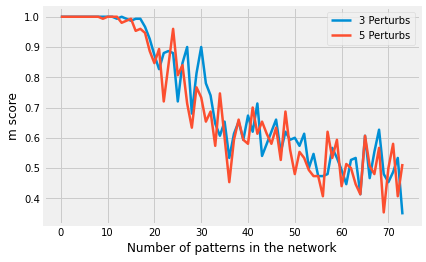

In [20]:
plt.plot(m_score_3,linewidth=2.5)
plt.plot(m_score_5,linewidth=2.5)
plt.legend(['3 Perturbs','5 Perturbs'],loc='upper right')
plt.xlabel('Number of patterns in the network')
plt.ylabel('m score')
plt.show()

The above plot is noisy and shows a somewhat downtrend with increase in number of patterns stored in the network irrespective of the number of bits flipped. Therefore, the network's ability to extract information is adversely affected with increase in number of patterns. 

#### C. Size of the network :
Analysing the behaviour of the model with increasing pattern size.<br>
Each datapoint has been iterated thrice and then the mean is taken into account inorder to reduce the effect of randomness.<br> <br>

- Number of patterns in the network = 10
- The size of the pattern ranges from 4 to 20

In [21]:
num_of_patterns=10
bitflip=5
m_score_5=[]
for pattern_size in range(4,21) :
    m=[]
    for i in range(3) :
        m.append(hopfield_network(pattern_size,num_of_patterns,bitflip,plots=False))
    m_score_5.append(np.mean(m))

In [22]:
num_of_patterns=10
bitflip=10
m_score_10=[]
for pattern_size in range(4,21) :
    m=[]
    for i in range(3) :
        m.append(hopfield_network(pattern_size,num_of_patterns,bitflip,plots=False))
    m_score_10.append(np.mean(m))

In [23]:
num_of_patterns=10
bitflip=15
m_score_15=[]
for pattern_size in range(4,21) :
    m=[]
    for i in range(3) :
        m.append(hopfield_network(pattern_size,num_of_patterns,bitflip,plots=False))
    m_score_15.append(np.mean(m))

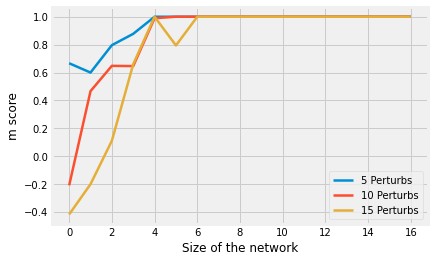

In [24]:
plt.plot(m_score_5,linewidth=2.5)
plt.plot(m_score_10,linewidth=2.5)
plt.plot(m_score_15,linewidth=2.5)
plt.legend(['5 Perturbs','10 Perturbs','15 Perturbs'],loc='lower right')
plt.xlabel('Size of the network')
plt.ylabel('m score')
plt.show()

The above plot suggests that if the number of bits flipped is kept constant and the size of the network keeps on increasing then there's a fair chance of the model performing brilliantly. If the number of bits flipped are much less when compared to the size of the network, the model is able to retrieve the information accurately. For small patterns flipping many bits will change the pattern significantly for the model to perform accurately.

### Converting MNIST dataset into patterns :

In [25]:
import mnist
from PIL import Image

In [26]:
#Importing the training images
training_images = mnist.train_images()
training_label = mnist.train_labels()

In [27]:
#Importing the test images
test_images = mnist.test_images()
test_labels = mnist.test_labels()

Checking the dimensions of the training and the test set:

In [28]:
print('Dimensions of training set: '+str(training_images.shape))

Dimensions of training set: (60000, 28, 28)


In [29]:
print('Dimensions of training set: '+str(test_images.shape))

Dimensions of training set: (10000, 28, 28)


- The training set has 60K images 
- The test set has 10K images 
- The images have a dimension of 28*28

The function below converts the MNIST dataset into patterns which can be used by the hopfield network created above. <br>
Thresholding has been used for preprocessing, where the threshold is taken as 128.

In [30]:
def convertThreshold(images,threshold=128,size=28) :
    image_list = []
    for i in range(len(images)):
        image = images[i].flatten()
        image=[image<threshold]
        im=[-1 if t else 1 for t in image[0]]
        im=np.array(im)
        im = np.reshape(im,(-1,size))   
        image_list.append(im)
    return image_list

In [31]:
train_processed=convertThreshold(training_images,threshold=128,size=28)

In [32]:
test_processed=convertThreshold(test_images,threshold=128,size=28)

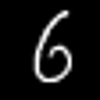

In [33]:
Image.fromarray(training_images[18]).resize((100,100))

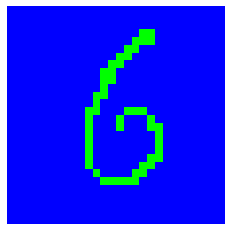

In [34]:
plot_tools.plot_pattern(train_processed[18])

### Classification using Hopfield Network :

In order to train the model, 200 preprocessed samples are taken randomly. The weights are calculated using the 200 samples and are further used for prediction.

In [35]:
np.random.seed(100)
shuffled_idx = np.random.randint(0,len(train_processed),1000)

In [36]:
y_train=training_label[shuffled_idx]

In [37]:
x_train=[]
for idx in shuffled_idx :
    x_train.append(train_processed[idx])

In [38]:
weights=calculate_weights(x_train,28)

To test the Hopfield Network, 20 random samples are selected from the test set and are used for prediction using the weights obtained above.

In [39]:
np.random.seed(100)
shuffled_idxs=np.random.randint(0,len(test_processed),20)

In [40]:
y_test=test_labels[shuffled_idxs]
x_test=[]
for idx in shuffled_idxs :
    x_test.append(test_processed[idx])

In [41]:
predict=[]
for test in x_test :
    S = test
    state_list = [test]
    for i in range(5):

            state_list.append(network_evolution(S,weights))
            #print(state_list[-1])
            S = state_list[-1]
    overlap=[]
    for p in x_train :
        overlap.append(pattern_tools.compute_overlap(state_list[-1], p))
    ind=np.argmax(overlap)
    predict.append(y_train[ind])

In [42]:
print(predict)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


The above network only predicts 1. There can be several reasons for this like there's not much variation in which 1 can be written.

In [43]:
accuracy=0
for i in range(len(y_test)) :
    if y_test[i]==predict[i] :
        accuracy=accuracy+1
accuracy=accuracy/len(y_test)

In [44]:
print('The accuracy of the model is: '+str(accuracy*100)+'%')

The accuracy of the model is: 25.0%


In [45]:
from sklearn.metrics import f1_score
f1=f1_score(y_test,predict,average='micro')
print('F1 score:',f1)

F1 score: 0.25


The F1 score of the above network is around 0.25 which is not really good when compared with other methods. 
However, there have been works which suggest that some more preprocesing on the dataset can help in increasing the accuracy of the model [Link](https://www.researchgate.net/publication/341712078_Classification_of_handwritten_digits_using_the_Hopfield_network).

#### Deskewing the images:
Source: https://fsix.github.io/mnist/Deskewing.html

In [46]:
from scipy.ndimage import interpolation

def moments(image):
    ''' Source: https://fsix.github.io/mnist/Deskewing.html'''
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

In [47]:
def deskew(image):
    '''Source: https://fsix.github.io/mnist/Deskewing.html'''
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)


#### Visualizing the deskewed output :
The code deskews the images, a few examples are printed below :

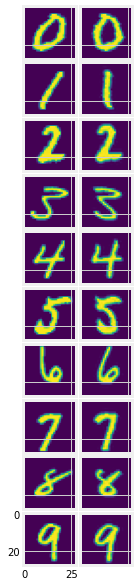

In [48]:
'''Source: https://fsix.github.io/mnist/Deskewing.html'''
examples = (4181, 0), (3,1), (56282, 2), (25829,3), (9741,4) , (26901,5), (50027,6), (17935,7) , (41495, 8), (14662, 9)
from mpl_toolkits.axes_grid1 import AxesGrid
grid = AxesGrid(plt.figure(figsize=(8,15)), 141,  # similar to subplot(141)
                    nrows_ncols=(10, 2),
                    axes_pad=0.05,
                    label_mode="1",
                    )

for examplenum,num in examples :
    im = grid[2*num].imshow(training_images[examplenum].reshape(28,28))
    im2 = grid[2*num+1].imshow(deskew(training_images[examplenum].reshape(28,28)))
    im1=deskew(training_images[examplenum].reshape(28,28))


Using the codes above the alignment of the images in the dataset is corrected. The above codes are used in pre-processing the dataset as discussed in the paper.

#### Generating a smaller dataset:
A smaller dataset is created and used for training. Training using all the 60K images will take alot of time and doesnot produce suitable results. <br> 
- The smaller training set contains 7 images for each digit.
- Therefore, the size of the smaller training set is 7*10 = 70

In [49]:
random.seed(101) # For reproducible results
idxs=[]
for i in range(10) :
    indx=np.where(training_label==i)
    temp=random.sample(list(indx[0]),7)
    idxs.extend(temp)    

In [50]:
y_train=training_label[idxs]
x_train=[]
for idx in idxs :
    x_train.append(training_images[idx])

Performing deskewing, image cropping and thresholding on the images of the smaller training set: <br>
- After cropping, each image has a dimension of 14*14
- The threshold for training images is taken as 86. [[Ref](https://www.researchgate.net/publication/341712078_Classification_of_handwritten_digits_using_the_Hopfield_network)]

In [51]:
image_list=[]
for i in range(len(x_train)) :
    im=deskew(x_train[i].reshape(28,28)) #Performs deskewing
    im=im[7:21,7:21] #Image Cropping
    image_list.append(im)

In [52]:
x_train=convertThreshold(image_list,threshold=86,size=14) # Performs Thresholding

Performing deskewing, image cropping and thresholding on the test set:
- The dimension of each image changes from 28X28 to 14X14 after cropping
- The threshold for test images is taken as 38. [[Ref](https://www.researchgate.net/publication/341712078_Classification_of_handwritten_digits_using_the_Hopfield_network)]

In [53]:
image_list=[]
for i in range(len(test_images)) :
    im=deskew(test_images[i].reshape(28,28))
    im=im[7:21,7:21] #Image Cropping
    image_list.append(im)

In [54]:
x_test=convertThreshold(image_list,threshold=38,size=14) # performs Thresholding
y_test=test_labels

#### Calculating the weights using the training images:

In [55]:
weights=calculate_weights(x_train,14)

#### Performing prediction on the test set :

In [56]:
predict=[]
for test in x_test :
    S = test
    state_list = [test]
    for i in range(1):
            state_list.append(network_evolution(S,weights))
            S = state_list[-1]
    
    overlap=[]
    for p in x_train :
        overlap.append(pattern_tools.compute_overlap(state_list[-1], p))
    ind=np.argmax(overlap)
    predict.append(y_train[ind])

In [57]:
from sklearn.metrics import accuracy_score 
print('Accuracy: '+str(accuracy_score(y_test, predict)*100)+'%')

Accuracy: 61.0%


In [58]:
print('F1 Score: '+str(f1_score(y_test,predict,average='micro')))

F1 Score: 0.61


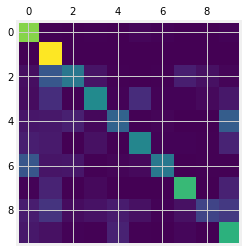

In [59]:
from sklearn.metrics import confusion_matrix
plt.matshow(confusion_matrix(y_test, predict))

#### Comparison with other models:
- Without performing cropping and deskew, our model only predicts 1. To use Hopfield Network for classification cropping and deskew is essential for producing good results. 
- Even after performing deskew and cropping our model can only achieve an accuracy of 61% whereas classical algorithms like SVM can easily achieve 90%+ accuracy.
- Deep learning models can easily achieve 99%+ accuracy even without performing deskew and cropping.
<br><br>
The performance of Hopfield Network as a classification algorith is really poor even after a lot of pre-processing.


#### Merits of Hopfield Network:
- The implementation of the algorithm is simple.
- Performs well if the number of patterns stored in the network is less and hence, can be used for few shot learning.
- Doesn't require labels during training which can be really helpful when there's a scarcity of labels.

#### Demerits of Hopfield Network :
- Hopfield netwrok cannot be used to train with alot of images.
- Performs poorly if the pattern to be recognised differs from the training pattern by more than 25%
- Lots of pre-processing is required for the model to perform nicely.
- The weight matrix has to be symmetrical, which is biologically not plausible

### Acknowledgements and References :
1. [Paper](https://www.researchgate.net/publication/341712078_Classification_of_handwritten_digits_using_the_Hopfield_network) has been really helpful for parameter tuning.
2. The docs from the webpage of neuronaldynamics were really helpful for [Implementation](https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/hopfield-network.html) 
3. My peers Manjyot Singh Nanra and Debdeep Paul Chaudhuri has helped me alot with hyperparameter tuning and other discussions related to assignment. 
4. [Demerits](https://www.skedsoft.com/books/neural-network-fuzzy-systems/limitations-to-using-the-hopfield-network)
5. [Deskewing](https://fsix.github.io/mnist/Deskewing.html)
6. Lecture slides by Nisheeth Srivastava